# import libraries

In [91]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import imp
imp.reload(lp)

<module 'LammpsPostProcess' from '/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/LammpsPostProcess.py'>

In [2]:
#matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!

# utility functions

In [34]:
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print('column already included!')
        return False
    return True

        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(title,dpi=75,bbox_inches='tight')
    plt.show()
    
def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()
    
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[a[i,j] for j in range(-int(ngrid/2),int(ngrid/2)+ngrid%2)] 
                              for i in range(-int(mgrid/2),int(mgrid/2)+mgrid%2)])

def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 xv,yv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    (ny,nx,nz) = crltn.shape
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata = np.arange(0,(int(n/2)+n%2)) * dx
    ydata = val[0,0:(int(n/2)+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-o',label=r'$x$')       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(int(m/2)+m%2)) * dy
    ydata = val[0:(int(m/2)+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-s', color = 'red',label=r'$y$')
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        ax.plot((xc,xc),ax.axis()[2:],'-.r')
        #
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return (xc, yc)


def GetSlice2d( hist, err,
         xv, yv, zv,
         xtol = 2.5,
         z = 0.0):
############################################################
####### Get a 2D slice out off a 3D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx,nz) = hist.shape
    indices = np.all([np.abs(zv-z)>0.0,np.abs(zv-z)<dx],axis=0) #--- filtering based on the given range
    #--- binning in xy
    flist = hist[indices]
    rvect = np.c_[yv[indices],xv[indices]]
    rx,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = xv[indices] ) #--- \sum r_i
    ry,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = yv[indices]) #--- \sum r_i
    error,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = err[indices] ) #--- \sum r_i
    fmean, bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = flist ) #--- 3d histogram
    count, bin_edges = np.histogramdd( rvect, bins = (ny, nx) ) #--- n_i

    count[count==0] = 1
    rx /= count 
    ry /= count 
    fmean /= count
    error /= count
    return rx, ry, fmean, error

def GetSlice1d( hist, err,
         xv, yv,
         xtol = 2.5,
         **kwargs):
############################################################
####### Get a 1D slice out off a 2D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx) = hist.shape
    if 'y' in kwargs:
        y = kwargs['y']
        indices = np.all([np.abs(yv-y)>0.0,np.abs(yv-y)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = xv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = nx, weights = xv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = nx, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = nx ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = nx, weights = flist ) #--- 3d histogram
    elif 'x' in kwargs:
        x = kwargs['x']
        indices = np.all([np.abs(xv-x)>0.0,np.abs(xv-x)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = yv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = ny, weights = yv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = ny, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = ny ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = ny, weights = flist ) #--- 3d histogram
        
    #--- binning in xy

    count[count==0] = 1
    rdist /= count 
    fmean /= count
    error /= count
    return rdist, fmean, error


def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc1d( crltn, err,
                 xv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 ylim=(-1.0,+1.0),
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn.copy() #--- only xy plane
#    (m,n)=val.shape
    #--- along x 
    xv2 = xv.copy()
    dx = xv2[1] - xv2[0]
    #
    xdata = xv2 #np.arange(0,(n/2+n%2)) * dx
    ydata = val #[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.errorbar( xdata, ydata,yerr = err, fmt='-o',label=r'$x$')       
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        ax.plot([xc,xc],ax.axis()[2:],'-.',color='black')
        #
#        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return xc


def DrawFrame(ax, alpha_xl,alpha_xr,alpha_yb,alpha_yt,linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
def MultipleFrames( path='', title='', irun = 0, nmax = 10000 ):
    i=0
    append = False
    while i < nmax:
        try:
            sarr0 = np.c_[np.loadtxt('%s%i/Run%s/%s'%(path,i,irun,title))].T
            #        print i,sarr0
            if not append:
                sarr = sarr0.copy()
                append = True
            else:
                sarr = np.concatenate((sarr,sarr0),axis=0)
        except:
            i+=1
    #        traceback.print_exc()
            continue
        i+=1
    return sarr

def MultipleFrames2nd( path='', title='', nrun = 0 ):
    i=0
    append = False
    while i < nrun:
        try:
            sarr0 = np.c_[np.loadtxt('%s/Run%s/%s'%(path,i,title))].T
            #        print i,sarr0
            if not append:
                sarr = sarr0.copy()
                append = True
            else:
                sarr = np.concatenate((sarr,sarr0),axis=0)
        except:
            i+=1
#            traceback.print_exc()
            continue
        i+=1
    return sarr

# Parameters

In [ ]:
#--- comment out if no parameter is passed as an env. variable
env_vars = !cat .env
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

path = os.environ.get('path')
#itime = int(os.environ.get('itime'))

In [84]:
#--- comment out parameters if you pass them
#--- by arguments

#--- timestep
#itime = 500000*2*2
dlgr0 = 2.5 #--- 1st peak  in g(r)
dlgr = 4.0 #--- 2nd peak in g(r) !!!!!!!!!!
cutoff = 10.0*4    #--- cut-off radius for g(r)
NMAX = 10000*4    #--- max. number of atoms included for the g(r) analysis
#
ReadStrsFromDump = False #--- if true: read stress from dump file
#
#--- if np.any(AssignYieldTime,AssignMaxDropTime,AssignFlowTime) -> comment itime 
AssignYieldTime = True #--- stress peak
AssignMaxDropTime = False #--- max drop
AssignFlowTime = False #--- flow stress
#
ShuffleDisp = False
CrltnFunctionUnstructured = False
PairCorrelationFunction = False
#
CommonNeighAnl = False #--- Read ovito output
#
StrnAnalysis = False
#
DminAnalysis = True
#
LatticeConstant = {1:58.933,2:58.690,3:51.960,4:55.847,5:54.940} #--- from library_CoNiCrFeMn.meam
#--- lammps output
#path = '/mnt/home/kkarimi/Project/git/CrystalPlasticity/testRuns/glassFeNi/Run0'
#path='/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/BmgData'

#--- bulk stress files
indx = 0
fileNamee = ('FeNi.txt', 
#              'CoNiCr.txt', 
             'CoNiFe.txt', 
             'CoNiCrFe.txt',
             'CoCrFeMn.txt',
             'CoNiCrFeMn.txt',
             'Co5Cr5Fe40Mn27Ni26.txt')[indx]

#--- xyz and atom-wise stress files
fileName = '%s/%s'%(path,[
            'FeNi_glass.dump',
#             'CoNiCr_glass.dump',
            'CoNiFe_glass.dump',
            'CoNiCrFe_glass.dump',
            'CoCrFeMn_glass.dump',
            'CoNiCrFeMn_glass.dump',
            'Co5Cr5Fe40Mn27Ni26_glass.dump'][indx])#--- parse cords

fileName2nd = '%s/%s'%(path,[
            'FeNi_Cna.xyz',
                            ][indx]) 


# input stress file

In [85]:
if not ReadStrsFromDump:
    stress = np.loadtxt('%s/%s'%(path,fileNamee) )

## Dump File

In [86]:
#--- parse lammps data
lmpData = lp.ReadDumpFile( fileName )
lmpData.GetCords( ncount = sys.maxsize, columns = {'c_mystress[4]':'sxy'} )
#lmpData.GetCords( ncount = sys.maxsize, 
#                   columns = {'c_mystress1':'sxx','c_mystress2':'syy','c_mystress3':'szz','c_mystress4':'sxy'} ) #!!!!!!
if CommonNeighAnl:
    lmpCna = lp.ReadDumpFile( fileName2nd )
    lmpCna.GetCords( ncount = sys.maxsize)


# stress-strain curve

BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!
BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!
BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!
BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!
BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!
BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!


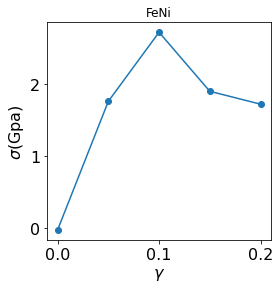

In [87]:
if ReadStrsFromDump:
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$\gamma$',fontsize=16)
    ax.set_ylabel(r'$\sigma$(Gpa)',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.set_title(fileNamee[:-4])
#
#--- point corresponding to strain maps
strainDump = []
Virial = []
times = lmpData.coord_atoms_broken.keys()
for itimee in sorted(times):

    #--- extract atom and box properties
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
    #
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee] )
    box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    #
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] ) #--- reference state
    box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

    #--- volume
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    
    #--- virial stress
    if ReadStrsFromDump:
        virial = np.sum(atoms.sxy) / volume
#        virial = -(np.sum(atoms.sxx)+np.sum(atoms.syy)+np.sum(atoms.szz)) / 3.0 / volume

    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1    
    
    #--- append
    strainDump += [ebulk]
    if ReadStrsFromDump:
        Virial += [virial*1e-4] #--- bar to gpa 
if ReadStrsFromDump:
    #
    ax.plot(np.array(strainDump), Virial, '-o')
    #
    plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
    np.savetxt('loadCurve.txt',np.c_[np.array(strainDump), Virial])
    plt.show()
#


In [88]:
if not ReadStrsFromDump:

    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$\epsilon$',fontsize=16)
    ax.set_ylabel(r'$\sigma$',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.set_title(fileNamee[:-4])
    #
    strain = stress[:,0]
    Virial = stress[:,1]
    ax.plot(strain,Virial,'-')
    #
    plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    np.savetxt('loadCurve.txt',np.c_[np.array(strain), Virial])

In [11]:
# sarr=np.loadtxt('%s/loadCurve.txt'%path)
# strain = sarr[:,0]
# Virial = sarr[:,1]

# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# ax.set_xlabel(r'$\gamma$',fontsize=16)
# ax.set_ylabel(r'$\sigma$(Gpa)',fontsize=16)
# ax.tick_params(labelsize=16)

# ax.plot(np.array(strain), Virial, '-o')
# plt.show()

## find stress peak and corresponding strain
### Fit a spline

ey= 0.09999999999999999
sy= 2.725491755274483
em= 0.15000000000057404


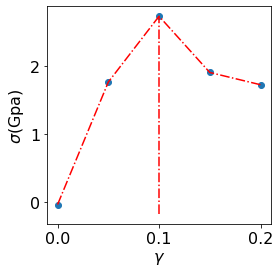

In [12]:

def ReturnShapeFunc(x,df):
#    eps1=0.0;eps2=0.0
#    n = len(x)
#    x2 = x * x
#    x3 = x * x2
#    x4 = (x-eps1)**3
#    x5 = (x-eps2)**3
    transformed_x = patsy.bs(x, df=df,degree =3, include_intercept=False)
    return transformed_x 

def TrainModel(x,y):
    reg = LinearRegression().fit(x, y )
    return reg

def Validate(reg, x,y,cv_samples=10):
    mse={}
#    for df in range(0,100,4):
    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
        try:
            transfrm = ReturnShapeFunc(x,df)
            #--- vadidate    
            scores = cross_validate(reg,  transfrm, y, cv=cv_samples,
                                         scoring=('r2', 'neg_mean_squared_error'),
                                         return_train_score=True)
            mse[df] = np.mean(scores['train_neg_mean_squared_error'])
        except:
            continue
    return mse

if ReadStrsFromDump:
    strain = strainDump

x, y = np.array(strain), np.array(Virial)
#--- training points
transfrm = ReturnShapeFunc(x,10)
    
#--- train
reg = TrainModel(transfrm,np.c_[y])

#--- prediction
y_pred = reg.predict( transfrm )
    

#--- validate
#mse = Validate(reg, strain,np.c_[y])

#--- max. stress
y_pred_arr = np.array(y_pred.flatten())
indx = np.arange(len(y_pred_arr))[y_pred_arr==np.max(y_pred_arr)][0]
ey =  x[indx]
print('ey=',ey)

#--- yield stress
sy =  y_pred_arr[indx]
print('sy=',sy)
assert sy > 0.0

#--- max. slope
ydiff = np.gradient(y_pred_arr, x)
indx = np.arange(len(x))[ydiff==np.min(ydiff[x>ey])][0]
em = x[indx]
sm =  y_pred_arr[indx]
print('em=',em)

#--- flow stress
ydiff = np.gradient(y_pred_arr, x)
indx = np.arange(len(x))[np.abs(ydiff)==np.min(np.abs(ydiff)[x>em])][0]
ef = x[indx]
sf =  y_pred_arr[indx]


#--- plot
fig = plt.figure( figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_ylabel(r'$\sigma$(Gpa)',fontsize=16)
ax.set_xlabel(r'$\gamma$',fontsize=16)
ax.tick_params(labelsize=16)
#
ax.plot( x, y,'o')
ax.plot(x, y_pred,'-.r')
if AssignYieldTime:
    ax.plot([ey,ey], [ax.axis()[2],sy],'-.r')
elif AssignMaxDropTime:
    ax.plot([em,em], [ax.axis()[2],sm],'-.r')
elif AssignFlowTime:
    ax.plot([ef,ef], [ax.axis()[2],sf],'-.r')
plt.savefig('fit.png',dpi=75,bbox_inches='tight')
plt.show()


In [13]:
times = lmpData.coord_atoms_broken.keys()
times = np.array(sorted(times))
if AssignYieldTime:
    itime = times[strainDump>=ey][0]
    print('itime(peak)=%s'%itime)    
elif AssignMaxDropTime:
    itime = times[strainDump>=em][0]
    print('itime(max. drop)=%s'%itime)
elif AssignFlowTime:
    itime = times[strainDump>=ef][0]
    print('itime(flow)=%s'%itime)

itime(peak)=1000000


### test error vs. complexity

In [14]:
keys=mse.keys()
plt.scatter(keys, [-mse[key] for key in keys],marker='x')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5,1e-2)
plt.savefig('cv.png',dpi=75,bbox_inches='tight')
plt.show()

NameError: name 'mse' is not defined

In [15]:
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# # ax.set_xlabel(r'$\epsilon$',fontsize=20)
# # ax.set_ylabel(r'$\sigma/\sigma_y$',fontsize=20)
# ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.tick_params(labelsize=16,which='both',axis='both', top=True, right=True)
# #ax.set_title(fileNamee[:-4])
# #
# FileNamee = ('FeNi.txt', 
#              'CoNiCr.txt', 
#              'CoNiCrFe.txt',
#              'CoCrFeMn.txt',
#              'Co5Cr2Fe40Mn27Ni26.txt')
# #FileNamee = ['CoNiCrFe.txt']
# #
# for fileNamee in FileNamee:
#     stress = np.loadtxt('%s/%s'%(path,fileNamee) )
#     #
#     ax.plot(stress[:,0],stress[:,1]/stress[:,1].max(),'-', label = fileNamee[:-4])
# ax.legend(frameon=False, fontsize=16)
# #
# DrawFrame(ax, (0.17,0.09),(0.15,0.06),0.04)
# #
# plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight')
# plt.show()

## mismatch parameter 

In [17]:
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
df = pd.DataFrame(atoms.__dict__)
size = list(map(LatticeConstant.get,list(map(int,df['type'].tolist()))))
assert len(size) == len(df)
df = pd.DataFrame(np.c_[df,size],columns=list(df.keys())+['size'])

delta = df['size'].std()/df['size'].mean()
np.savetxt('YieldDelta.txt',np.c_[delta,sy],header='AtomMismatch\tYieldStress')

### multiple frames

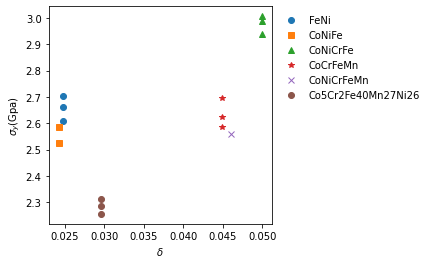

In [51]:
sarr0 = MultipleFrames2nd(path='yieldDStrsFeNi',nrun=3,title='YieldDelta.txt')
sarr1 = MultipleFrames2nd(path='yieldDStrsCoNiFe',nrun=3,title='YieldDelta.txt')
sarr2 = MultipleFrames2nd(path='yieldDStrsCoNiCrFe',nrun=3,title='YieldDelta.txt')
sarr3 = MultipleFrames2nd(path='yieldDStrsCoCrFeMn',nrun=3,title='YieldDelta.txt')
sarr4 = MultipleFrames2nd(path='yieldDStrsCoNiCrFeMn',nrun=3,title='YieldDelta.txt')
sarr5 = MultipleFrames2nd(path='yieldDStrsCo5Cr5Fe40Mn27Ni26',nrun=3,title='YieldDelta.txt')
#
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel('$\delta$')
ax.set_ylabel('$\sigma_y$(Gpa)')
#ax.set_ylim(1,4)
#ax.set_yscale('log')
#
ax.plot(sarr0[:,0],sarr0[:,1],'o',label='FeNi')
ax.plot(sarr1[:,0],sarr1[:,1],'s',label='CoNiFe')
ax.plot(sarr2[:,0],sarr2[:,1],'^',label='CoNiCrFe')
ax.plot(sarr3[:,0],sarr3[:,1],'*',label='CoCrFeMn')
ax.plot(sarr4[:,0],sarr4[:,1],'x',label='CoNiCrFeMn')
ax.plot(sarr5[:,0],sarr5[:,1],'o',label='Co5Cr2Fe40Mn27Ni26')
#
ax.legend(frameon=False,bbox_to_anchor=(1,1) )
plt.savefig('YieldDelta.png',dpi=75,bbox_inches='tight')
plt.show()

In [38]:
sarr0[:,1].std()/len(sarr0[:,1])**.5

0.02282254812098038

# Plastic Deformation


## Compute Displacements


In [89]:

#--- extract atom and box properties
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
#
box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
  
#--- wrap coordinates
wrap = lp.Wrap( atoms, box )
wrap.WrapCoord()
wrap.Set( atoms ) #--- atoms: set wrapped xyz     

#--- print actual xyz
# PrintOvito( pd.DataFrame(atoms.__dict__), 
#              open( 'xyz_actual.xyz','w'), 
#              footer = 'ITIME=%s'%itime,
#              attr_list=['id','type','x','y','z'])

#--- map to square box
mapp = lp.Map( atoms, box ) 
mapp.ChangeBasis()
mapp.Set( atoms ) #--- atoms: add mapped xyz

#--- print mapped xyz
# PrintOvito( pd.DataFrame(atoms.__dict__), 
#             open( 'xyz_mapped.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','xm','ym','zm'] )

#--- include copies
copy = lp.Copy( atoms, box )
copy.FullCopies()
xatoms = copy.Get()

#--- print mapped xyz
# PrintOvito( pd.DataFrame(xatoms.__dict__), 
#             open( 'xyz_full.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','xm','ym','zm'] )

#--- compute displacements
#--- need attributes for the reference state
atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='list') )
box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
wrap = lp.Wrap( atoms0, box0 )
wrap.WrapCoord()
wrap.Set( atoms0 ) #--- atoms: set wrapped xyz    
mapp = lp.Map( atoms0, box0 ) 
mapp.ChangeBasis()
mapp.Set( atoms0 ) #--- atoms: add mapped xyz
copy = lp.Copy( atoms0, box0 )
copy.FullCopies()
xatoms0 = copy.Get()
#
cdisp = lp.ComputeDisp( xatoms, box, xatoms0, box0 ) #--- pass full copies!
cdisp.SetWrapped() 
uatoms = cdisp.Get(attrs = ['id','type','x','y','z','xm','ym','zm','dx','dy','dz'] ) #--- all atom-wise props
#
pd.DataFrame(uatoms.__dict__).head()

BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!


,x,y,z,id,type,xm,ym,zm,dx,dy,dz
0,4.73092,-20.57810,-41.4164,1.0,4.0,4.73092,-20.57810,-41.4164,-3.608210,2.17550,-0.0385
1,-5.47277,-15.50650,-11.9452,2.0,2.0,-5.47277,-15.50650,-11.9452,-4.445540,1.78990,-0.5205
2,-35.09840,26.30910,27.5002,3.0,2.0,-35.09840,26.30910,27.5002,5.622822,-1.83440,-0.0146
3,-35.96470,-2.19362,-39.5794,4.0,2.0,-35.96470,-2.19362,-39.5794,-0.076878,-0.88144,0.0235
4,30.55360,-33.67560,-25.6883,5.0,2.0,30.55360,-33.67560,-25.6883,-6.285400,-0.01520,0.4930


In [74]:
# #--- shuffled displacements
if ShuffleDisp:
    xrand = np.c_[uatoms.dx,uatoms.dy,uatoms.dz]
    np.random.shuffle(xrand)
    junk = np.c_[uatoms.id, uatoms.type, uatoms.x, uatoms.xm, uatoms.y, uatoms.ym, uatoms.z,
           uatoms.zm]
    cols = [u'id', u'type', u'x', u'xm', u'y', u'ym', u'z',u'zm']
    #np.c_[junk,xrand]
    uatoms = lp.Atoms(**pd.DataFrame(np.c_[junk,xrand],columns=cols+['dx','dy','dz']).to_dict(orient='list'))

### Print

In [75]:
#--- get a chunk
# cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
# indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
#                                   epsilon = 0.0, mode = 'isotropic' )


# PrintOvito( pd.DataFrame(uatoms.__dict__)[indices], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','x','y','z','dx','dy','dz'] )

## D2min

### Compute pair correlation function

In [90]:
if PairCorrelationFunction:
    rdf = lp.ComputeRdf(  atoms, box, 
                       cutoff = cutoff, NMAX = NMAX)

    rdf.Distance(WRAP = True)
    rdf.PairCrltn( nbins = 32 )
    bin_edges, hist, err = rdf.Get()

    #--- plot
    plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')
    plt.show()

### partition the space, make fits, and compute squared errors 

In [93]:
if DminAnalysis:
    #--- Create "Atoms" object with dx,x attributes and
    #--- atoms within the original box
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.0, mode = 'isotropic' )
    #--- filter the full copy
    atomd = lp.Atoms(**pd.DataFrame(uatoms.__dict__)[indices].to_dict(orient='list'))
    #
    d2min = lp.ComputeD2min(atomd, box0, dlgr)
    d2min.Partition()
    d2min.D2min()
#    pdb.set_trace()
    d2min = d2min.Get(attrs=['id','type','x','y','z','xm','ym','zm','d2min'])
    #
    pd.DataFrame(d2min.__dict__).head()

### Print

In [68]:
if DminAnalysis:
    #--- print 
    file_name = 'd2min.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass



    PrintOvito( pd.DataFrame(d2min.__dict__), 
                open(file_name,'a'), 
                footer = 'ITIME=%s'%itime,
                attr_list=['id','type','xm','ym','zm','d2min'] )

    # #--- current frame
    # d2minList=pd.DataFrame(d2min.__dict__).sort_values(by='id', ascending=True, inplace=False)['d2min']
    # df = pd.DataFrame(atoms.__dict__).sort_values(by='id', ascending=True, inplace=False)
    # #attrs = 
    # d2min2 = lp.Compute( atoms, box )
    # d2min2.Set(np.c_[df,d2minList],attrs=list(df.keys()) + ['d2min'])
    # attrs = ['id','type','x','y','z','d2min']
    # d2min2 = pd.DataFrame(np.c_[list(map(d2min2.__dict__.get,attrs))].T, columns = attrs )
    # PrintOvito( d2min2, 
    #             open(file_name,'a'), 
    #             footer = 'ITIME=%s'%itime,
    #             attr_list=['id','type','x','y','z','d2min'] )



### Interpolate

In [94]:
if DminAnalysis:

    #--- mean dist between atoms 
    natoms = len( atoms0.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))


    #--- expand the original box
    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.1, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.c_[d2exp.d2min] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))



#### Imshow

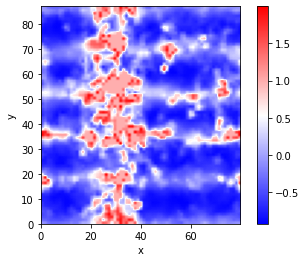

In [95]:
if DminAnalysis:

    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[d2intrp.d2min].reshape(((ny,nx,nz)))

    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = 'd2min.png',
            )

### Crltn Function (Unstructured points)

In [97]:
if DminAnalysis and CrltnFunctionUnstructured:
    crltn = lp.ComputeCrltn(  d2min, box, 
                              d2min.d2min, #--- values
                              cutoff = cutoff, #--- cutoff size to include neighbors
                              dx = dlgr0, #--- discretization length: 1st peak in rdf
                              NMAX = NMAX, #--- upper bounds for the number of atoms
                            )
    crltn.Distance()
    crltn.AutoCrltn(RADIAL = None)
    xvv, yvv, zvv, hist, err = crltn.Get()

    #--- save data
    np.save('CrltnFuncUnstructured',np.c_[xvv, yvv, zvv, hist, err])

In [202]:
# n=1000*4
# xyz = np.random.random((n,3)) 
# atom_tmp = lp.Atoms(**pd.DataFrame(np.c_[np.arange(n),np.ones(n),xyz],
#                                    columns=['id','type','x','y','z']).to_dict(orient='list'))
# box_tmp = lp.Box(CellOrigin=np.array([0,0,0]),CellVector=np.array([[1,0,0],[0,1,0],[0,0,1]]))
# #val = np.sin(2*np.pi*xyz[:,0])
# rstar = 0.25
# xyz = xyz - np.array([0.5,0.5,0.5])
# val = np.exp(-0.5*(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)/rstar/rstar)
# crltn = lp.ComputeCrltn(    atom_tmp, box_tmp,
#                              val,
#                              cutoff=1.0*3**.5, dx=0.05,
#                              NMAX = n
#                      )
# crltn.Distance()
# crltn.AutoCrltn(RADIAL = None)
# xvv, yvv, zvv, hist, err = crltn.Get()

# dlgr0 = 0.05/2

#### Plot Crltns

In [203]:
#--- load data
# sdata = np.load('CrltnFuncUnstructured.npy')
# nz = sdata.shape[2]/5
# xv = sdata[:,:,0:nz]
# yv = sdata[:,:,nz:2*nz]
# zv = sdata[:,:,2*nz:3*nz]
# hist = sdata[:,:,3*nz:4*nz]
# err = sdata[:,:,4*nz:5*nz]

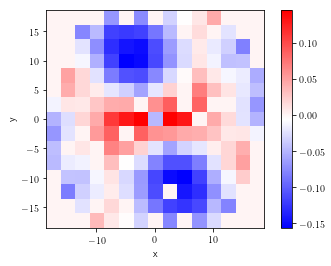

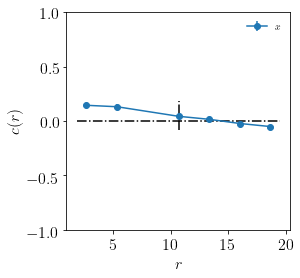

10.699313962120927

In [219]:
if DminAnalysis and CrltnFunctionUnstructured:
    #--- get 2d slice
    xv2d, yv2d, hist2d, err2d = GetSlice2d( hist, err,
                                           xvv, yvv, zvv,
                                           z=0.0, xtol = dlgr0/2
                                          )
    #--- bitmap
    PltBitmap(hist2d, 
              xlabel = 'x', ylabel = 'y',
              xlim=(xv2d.min(),xv2d.max()),ylim=(yv2d.min(),yv2d.max()),
              zscore = None,
              frac = 1.0, #--- plot a patch
              ) 

    #--- get 1d slice
    xv1d, hist1d, err1d =   GetSlice1d( hist2d, err2d,
                                 xv2d, yv2d,
                                 xtol = dlgr0/2,
                                 y=0.0)   
    #--- plot
    PltCrltnFunc1d( hist1d[xv1d>0.0], err1d[xv1d>0.0],
                     xv1d[xv1d>0.0],
                     fileName = 'cr.%s.png'%itime,
    #                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                     cTOL = 8.0e-2,
                     dpi = 60,
                    )

### Crltn Function (FFT)

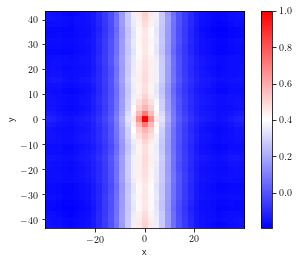

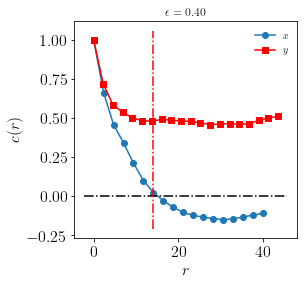

In [115]:
if DminAnalysis:
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[d2intrp.d2min].reshape((ny,nx,nz))

    #--- shuffle
    #     ( nx, ny, nz ) =  value.shape
    #     slist = value.flatten()
    #     np.random.shuffle(slist)
    #     value=slist.reshape((nx, ny, nz))    
    #
    #--- filter value
    #     value = FilterMatrix( CellVector[0], CellOrigin[0],
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )

    crltn = GetAutoCorrelation( value )


    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #    

    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy_d2min.%s.png'%itime,
              dpi = 60
            )

    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1
    #---
    xc, yc = PltCrltnFunc(   crltn, 
                             xv,yv,
                             fileName = 'cr_d2min.%s.png'%itime,
                             title = r'$\gamma=%3.2f$'%(ebulk),
                             cTOL = 8.0e-2,
                #             dpi = 60,
                            )
    #--- save
    np.savetxt('rc_d2min.txt',np.c_[ebulk, xc, yc],header='gamma\txc\tyc')

#### Multiple Frames

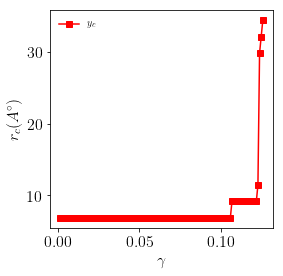

In [311]:
sarr = MultipleFrames('glassFeNi','rc_d2min.txt')
#--- plot
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
xstr = r'$\gamma$'
ystr = r'$r_c(A^\circ)$'
ax.set_xlabel(xstr,fontsize=16)
ax.set_ylabel(ystr,fontsize=16)
ax.tick_params(labelsize=16)
#
#ax.plot( sarr[1:,0], sarr[1:,1],'-o', color='C0', label = r'$x_c$')
ax.plot( sarr[1:,0], sarr[1:,2],'-s', color='red', label = r'$y_c$')
ax.legend(frameon=False)
plt.savefig('rc.png',dpi=75,bbox_inches='tight')
plt.show()


## Local Order Analysis

In [40]:
if CommonNeighAnl:
    #--- extract atom and box properties
    cna = lp.Atoms( **lmpCna.coord_atoms_broken[itime].to_dict(orient='list') )

### Histograms

NameError: name 'cna' is not defined

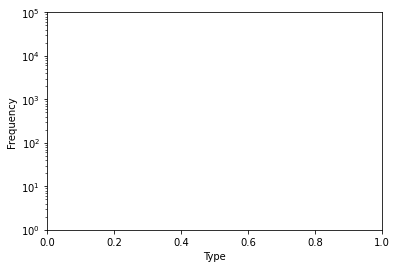

In [18]:
if CommonNeighAnl:
    #
    plt.yscale('log')
    plt.ylim(1,1e5)
    plt.xlabel('Type')
    plt.ylabel('Frequency')
    #
    x, y = np.unique(pd.DataFrame(cna.__dict__)['StructureType'], return_counts=True) #bug !!! len(y)!=5
    plt.bar(x, y)
    #
    plt.show()
    #--- strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = [dx/l1]

    #--- save
    np.savetxt('StructureTypeCounts.txt',np.array(ebulk+list(map(int,y))).reshape((1,6)),
               header='Strain,n0,n1,n2,n3,n4', fmt='%s')


#### Multiple Frames

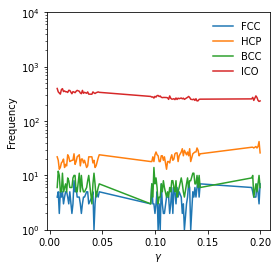

In [142]:
if CommonNeighAnl:
    sarr = MultipleFrames(path='StructureTypeFeNi',irun=1,title='StructureTypeCounts.txt')
    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$\gamma$')
    ax.set_ylabel('Frequency')
    ax.set_ylim(1e0,1e4)
    ax.set_yscale('log')
    #
    #ax.plot(sarr[:,0],sarr[:,1],label='Other')
    ax.plot(sarr[:,0],sarr[:,2],label='FCC')
    ax.plot(sarr[:,0],sarr[:,3],label='HCP')
    ax.plot(sarr[:,0],sarr[:,4],label='BCC')
    ax.plot(sarr[:,0],sarr[:,5],label='ICO')
    #
    ax.legend(frameon=False)
    plt.savefig('StructureTypeGamma.png',dpi=75,bbox_inches='tight')
    plt.show()

### Crltns with d2min

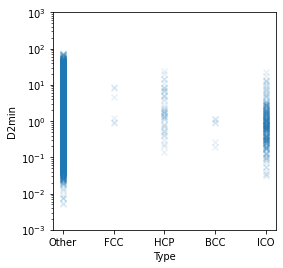

In [124]:
if CommonNeighAnl and DminAnalysis:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Type')
    ax.set_ylabel('D2min')
    ax.set_ylim(1e-3,1e3)
    ax.xaxis.set_ticks([0,1,2,3,4])
    ax.xaxis.set_ticklabels(['Other','FCC','HCP','BCC','ICO'])
    
    ax.set_yscale('log')
    ax.scatter(pd.DataFrame(cna.__dict__).sort_values(by='id')['StructureType'],
                pd.DataFrame(d2min.__dict__).sort_values(by='id')['d2min'],
                alpha = 0.1,
                marker='x'
               )

## Displacement Gradients

### Interpolate Displacements
#### cubic grid

In [91]:
#--- mean dist between atoms 
natoms = len( atoms0.x ) 
CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0) 

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                 box0.CellVector, 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))


#### center box + margin

In [92]:
if StrnAnalysis:
    #--- get a chunk of the full copy
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.2, mode = 'isotropic' )

    points = np.c_[uatoms.xm,uatoms.ym,uatoms.zm][indices] #--- unstructured points
    values = np.c_[uatoms.dx,uatoms.dy,uatoms.dz][indices] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    uintrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','dx','dy','dz']).to_dict(orient='list'))



#### Print

In [289]:
if StrnAnalysis:

    file_name = 'uintrp.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    #for itime in df_intrp:
    PrintOvito( pd.DataFrame( uintrp.__dict__ ), 
                    open( file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
                    attr_list=['x','y','z','dx','dy','dz'] )


### Strain tensor

In [93]:
if StrnAnalysis:
    csn = lp.ComputeStrn( uintrp, box0 )
    csn.Reshape( xlin, ylin, zlin )
    csn.Gradient()
    csn.SetStrn('exy')
    Exy = csn.Get(attrs = ['x','y','z','exy'])


#### imshow

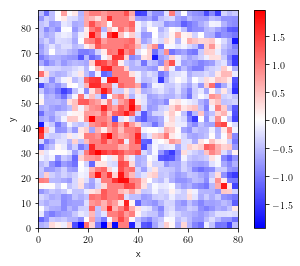

In [96]:
def FilterMatrix( CellVector, CellOrigin,
                  xlin, ylin, zlin,
                  xv, yv, zv ,
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf



if StrnAnalysis:

    #itime = np.max(dfD2min_intrp.keys())
    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[Exy.exy].reshape(((ny,nx,nz)))
    #value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))

    # lx=xlin[-1]-xlin[0]
    # ly=ylin[-1]-ylin[0]
    # #value = np.sin(2*pi*np.c_[(df_intrp[itime]['x']-xlin[0])]/lx)
    # value = np.c_[df_intrp[itime]['ux']]
    # value = value.reshape(((ny,nx,nz)))
    #print value.shape

    #--- filter value
    # value = FilterMatrix( box0.CellVector, box0.CellOrigin,
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )
    #print value.shape
    #print vf.shape

    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()
    #val = value[:,:,nz/2].copy()
    #print val.shape

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
               title = 'strain.png',
           )

In [89]:
# fig=plt.figure(figsize=(4,4))
# ax=fig.add_subplot(111)
# ax2=ax.twinx()

# # ax.set_xlim(min(xlin),max(xlin))
# # ax2.set_xlim(min(xlin),max(xlin))
# # ax.set_ylim(-1,1)
# # ax2.set_ylim(-1,1)

# f = val[:,0]
# df=val0[:,0]

# dx=xlin[1]-xlin[0]
# ax.plot(ylin, f,'-o',label='uy')
# #ax2.plot(ylin, np.gradient(f,xlin,edge_order=2)/(2*pi/lx),'-s',color='red',label='duydx')
# ax2.plot(ylin, np.gradient(f,ylin,edge_order=2),'-s',color='red',label='duydx')
# #ax2.plot(xlin[:-1], np.diff(f)/dx/(2*pi/lx),'-s',color='red',label='duydx')
# #ax2.plot(ylin,df/(2*pi/lx),'-x',color='black',label='duydxFFT')
# ax2.plot(ylin,df,'-x',color='black',label='duydxFFT')


# ax2.legend()
# plt.show()

In [90]:
# itime = np.max(Strain.keys())
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 

# # value = np.sin(2*pi*np.c_[df_intrp[itime]['x']]/nx)
# # value = value.reshape(((ny,nx,nz)))
# #dvalux = GetDerivX( value,lx )

# #value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
# dvaluy = GetDerivY( value,ly )

# exy=dvaluy
# #--- xy plane
# value0 = exy[:,:,-1].copy()

# PltBitmap(value0, 
#           xlabel = 'x', ylabel = 'y',
#           xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#           zscore = None,
#           frac = 1.0, #--- plot a patch
#         )

#### Print

In [30]:
if StrnAnalysis:

    file_name = 'strain.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    # times = Strain.keys()
    # times.sort()
    #--- bulk strain
    dx=box.CellVector[0,1]-box.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = 0.5*dx/l1


    PrintOvito( pd.DataFrame(Exy.__dict__), 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','exy'] )
    

#### Auto-Correlations

In [97]:
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real

if StrnAnalysis:

    #Crltn = {}
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[Exy.exy].reshape((ny,nx,nz))
    #    value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))
    #    value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))

    #--- shuffle
    #     ( nx, ny, nz ) =  value.shape
    #     slist = value.flatten()
    #     np.random.shuffle(slist)
    #     value=slist.reshape((nx, ny, nz))    
        #
    #--- filter value
    #     value = FilterMatrix( CellVector[0], CellOrigin[0],
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )

    Crltn = GetAutoCorrelation( value )


#### Print

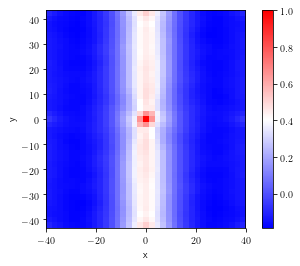

In [99]:
if StrnAnalysis:

    # for itime in Crltn:
    #     print 'itime=',itime
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    
    crltn = Crltn #[ itime ]
    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy_strain.%s.png'%itime,
              dpi = 60
            )
        # #--- zx plane
        # val = crltn[0,:,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'x',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )
        # #--- zy plane
        # val = crltn[:,0,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'y',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )



#### Crltn Length

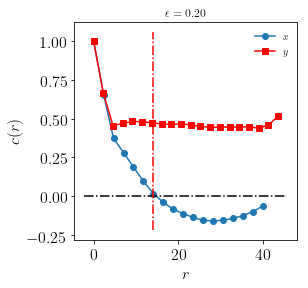

(14.108201970564707, nan)

In [107]:
if StrnAnalysis:

    # for itime in Crltn:
    #     print 'itime=',itime
    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = 0.5*dx/l1
    #---
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_strain.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )

In [109]:
# #--- extract length
# ebulk = []
# Xc = []
# Yc = []
# keys = Crltn.keys()
# keys.sort()
# for itime in keys:
#     #--- bulk strain
#     dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
#     l1=CellVector[ itime ][1,1]
#     ebulk += [0.5*dx/l1]
    
#     xc, yc = PltCrltnFunc( Crltn[ itime ], 
#                           (xv,yv),
#                           cTOL = 4e-2,
#                           PLOT = None,
#                          )
#     Xc += [xc]
#     Yc += [yc]

# #--- plot
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# xstr = r'$\epsilon$'
# ystr = r'$r_c$'
# ax.set_xlabel(xstr,fontsize=16)
# #ax.set_ylabel(ystr,fontsize=16)
# ax.tick_params(labelsize=16)
# #
# ax.plot( 2*np.array(ebulk), Xc,'-o', color='C0', label = r'$x_c$')
# ax.plot( 2*np.array(ebulk), Yc,'-s', color='red', label = r'$y_c$')
# ax.legend(frameon=False)
# plt.savefig('rc.png',dpi=75,bbox_inches='tight')
# plt.show()
